# InSituPy demonstration - Differential gene expression analysis

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, CACHE

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path(CACHE / "out/demo_insitupy_project")

In [5]:
xd = InSituData.read(insitupy_project)

In [6]:
xd.load_images()
xd.load_cells()

In [7]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 156447 × 297
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco', 'cell_type_dc_sub', 'cell_type_publ'
           var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
           uns: 'cell_type_dc_colors', 'cell_type_dc_sub', 'cell_type_dc_sub_colors', 'cell_type_publ_colors', 'cell_type_tacco_colors', 'counts_location', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'OT',

In [8]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo",
    scale_factor=0.2125
)

In [9]:
xd.import_regions(
    files="./demo_regions/demo_regions.geojson",
    keys="Demo",
    scale_factor=0.2125
)

### Visualize annotations
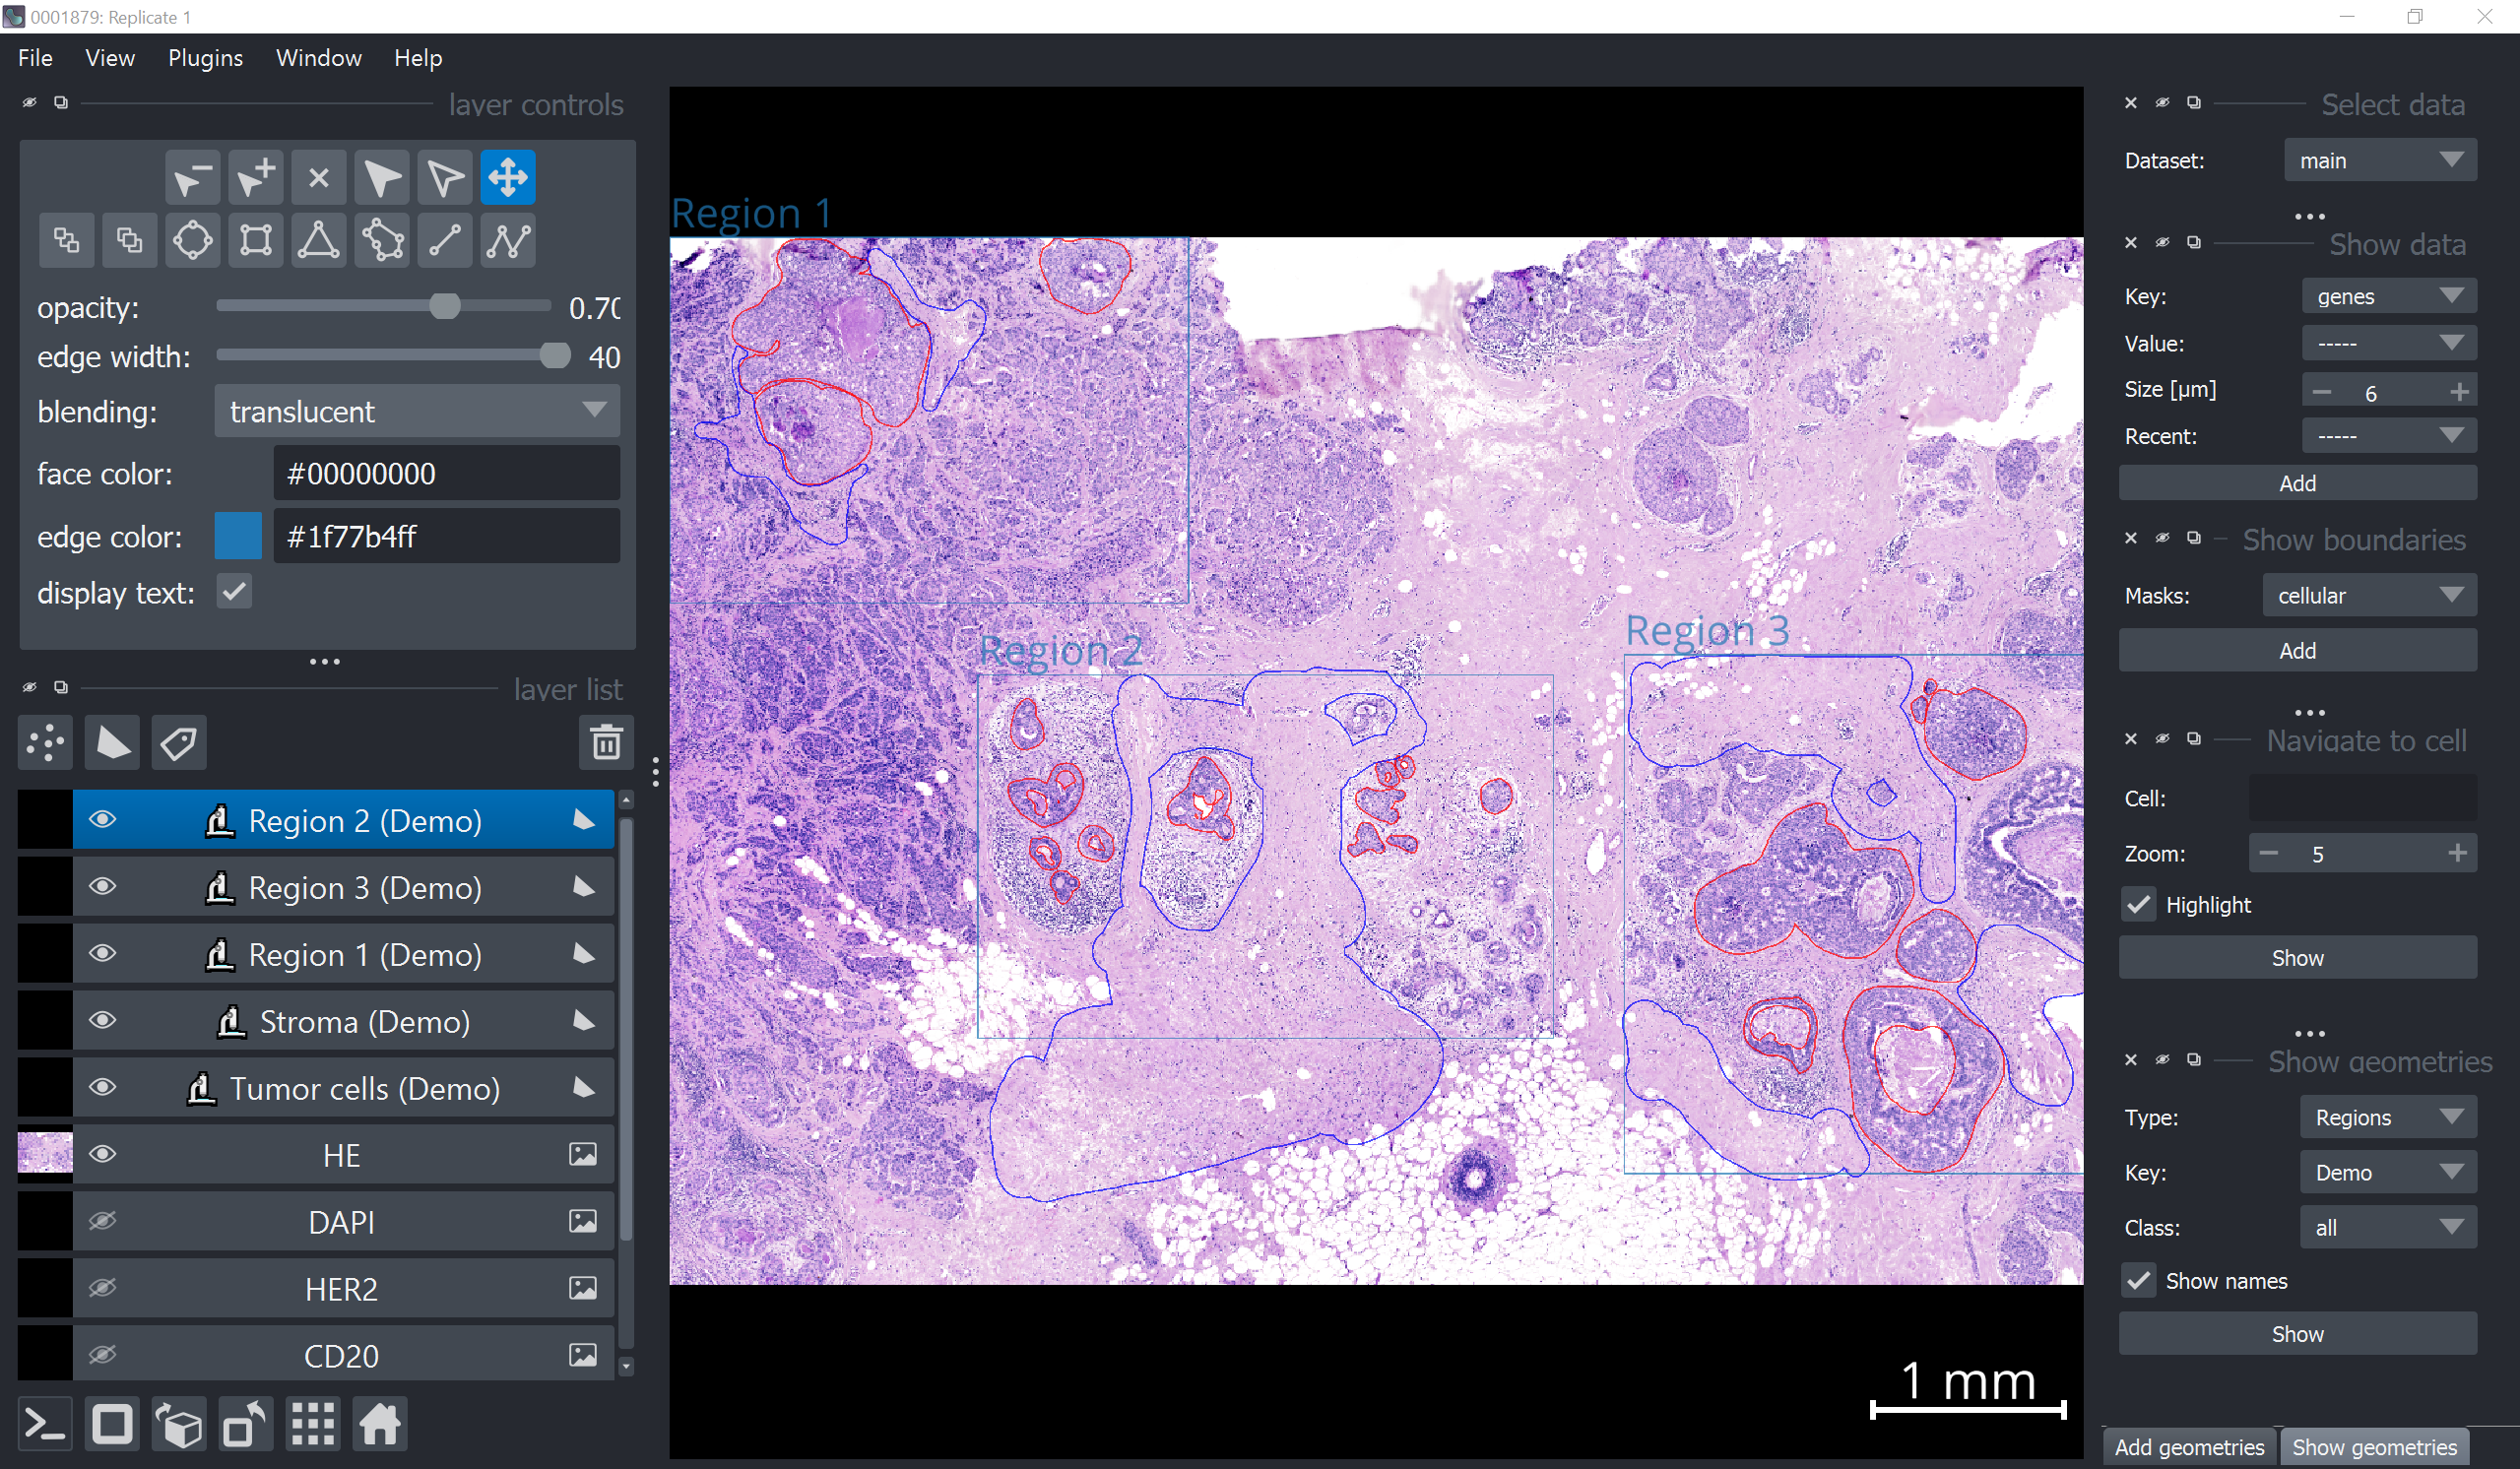

In [10]:
xd.show()

## Perform sample-level differential gene expression analysis using `InSituData`

In [10]:
from insitupy import differential_gene_expression

### Scenario 1: Comparison of two annotations within one dataset

Restrict analysis to annotation 'Tumor cells' from key 'Demo'.
Restrict analysis to annotation 'Stroma' from key 'Demo'.
Exclude ambiguously assigned cells...


C:\Users\ge37voy\Github\InSituPy\insitupy\_core\insitudata.py:2218: UserWarning: 6 (0.0%) cells were found to belong to both data and reference. This can happen due to overlapping annotations or non-unique cell names in the individual datasets. If you are sure that the same cell cannot be found in both data and reference, you can ignore this warning. To exclude ambiguously assigned cells from the analysis, use `exclude_ambiguous_assignments=True`.
  


Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
0 [0.89304717 0.79584591]
2 [-0.20560187  0.04548714]


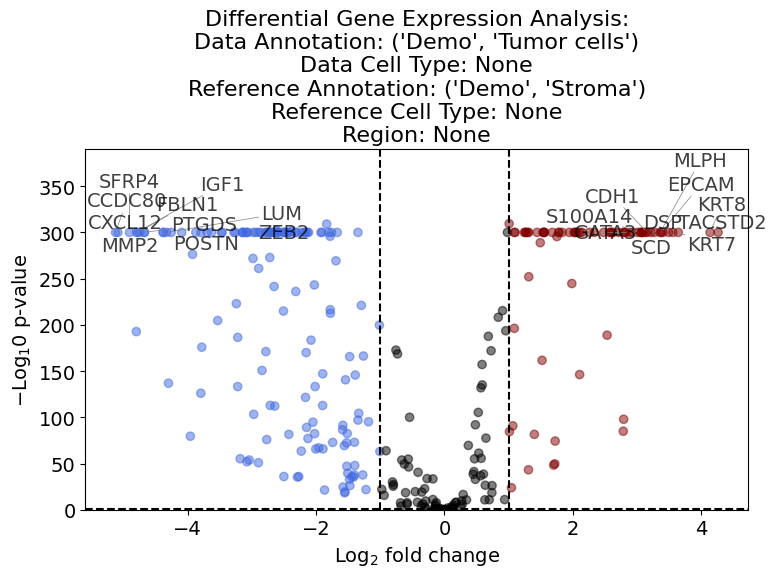

In [22]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    exclude_ambiguous_assignments=True,
    label_top_n=10
)

### Scenario 2: Comparison of two annotations within one dataset - restrict analysis to a specific region

Restrict analysis to region 'Region 3' from key 'Demo'.
Restrict analysis to annotation 'Tumor cells' from key 'Demo'.
Restrict analysis to region 'Region 3' from key 'Demo'.
Restrict analysis to annotation 'Stroma' from key 'Demo'.
Exclude ambiguously assigned cells...
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
11 [0.86679203 0.20733239]
15 [ 0.41003364 -0.70266558]


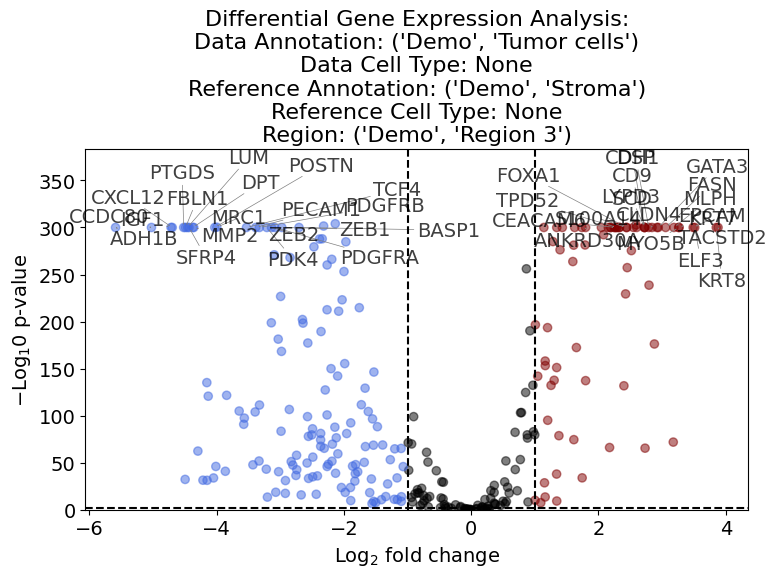

In [23]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    region_tuple=("Demo", "Region 3"),
    exclude_ambiguous_assignments=True, # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
)

## Experiment-level differential gene expression analysis

The clear structure of `InSituExperiment` lets us easily plan complex differential gene expression analysis across multiple samples. In the following, different Scenarios are shown how this can be done.

For more information on the `InSituExperiment` object see [here](./09_InSituPy_InSituExperiment.ipynb).

### Creating `InSituExperiment` object

In a first step the region annotations are used to split the dataset and create a `InSituExperiment` object.

In [24]:
from insitupy import InSituExperiment

In [25]:
exp = InSituExperiment.from_regions(
    data=xd,
    region_key="Demo",
    region_names=None # defaults to all regions
)
exp

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_key region_name
0     32db5a3e  0001879  Replicate 1       Demo    Region 1
1     88c93476  0001879  Replicate 1       Demo    Region 2
2     2ee8a51f  0001879  Replicate 1       Demo    Region 3

#### Scenario 1: Comparison of cell types between two samples

##### Scenario 1.1: Using the `InSituData` objects

First, the datasets of interest are extracted from the `InSituExperiment` object and subsequently processed using the `differential_gene_expression` function. In contrast to the previous examples we use now two different datasets.

In [26]:
xd0 = exp.data[0]
xd1 = exp.data[1]
xd2 = exp.data[2]

In [27]:
exp

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_key region_name
0     32db5a3e  0001879  Replicate 1       Demo    Region 1
1     88c93476  0001879  Replicate 1       Demo    Region 2
2     2ee8a51f  0001879  Replicate 1       Demo    Region 3

##### With one reference dataset

Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


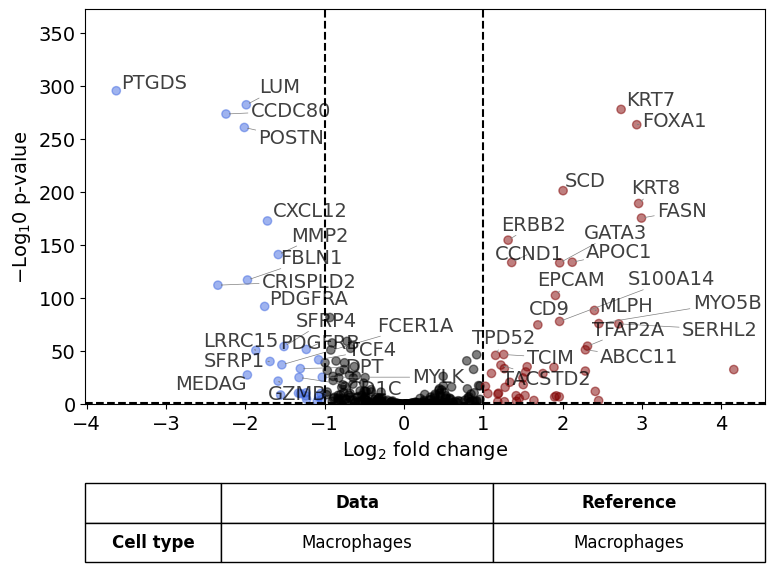

In [140]:
differential_gene_expression(
    data=xd0,
    ref_data=xd1,
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=False, # in this case we are sure that there

)

##### With list of reference datasets

Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


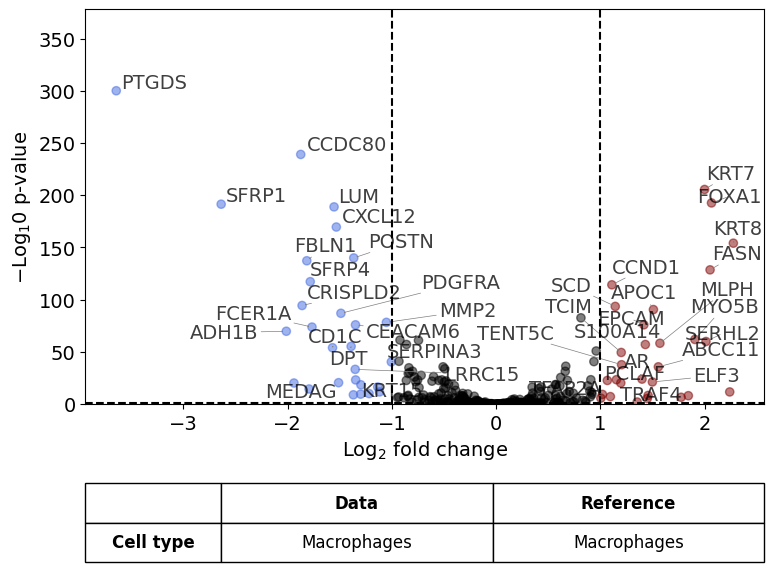

In [149]:
differential_gene_expression(
    data=xd0,
    ref_data=[xd1, xd2],
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=False, # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
)

##### Scenario 1.2: Using the `InSituExperiment` objects

Instead of extracting the `InSituData` objects first, we can also perform the DGE analysis directly on the `InSituExperiment` object using its `dge()` function.

##### With one reference dataset

Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Restrict analysis to cell type 'Macrophages' from .obs column 'cell_type_dc_sub'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


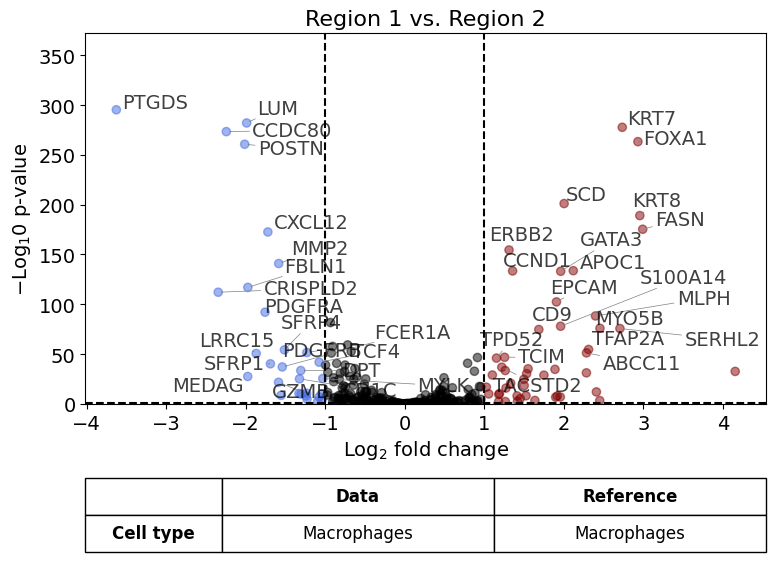

In [151]:
exp.dge(
    data_id=0,
    ref_id=1,
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=False,
    name_col="region_name"
)

##### With list of reference datasets

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


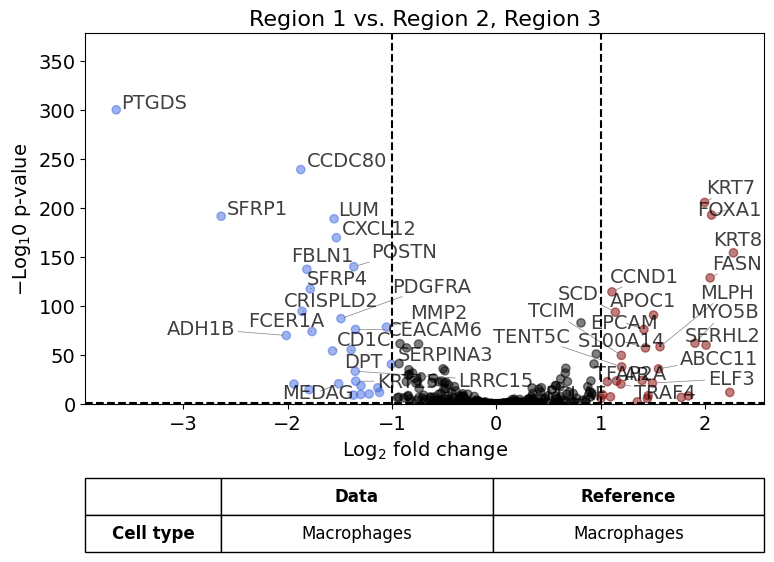

In [156]:
exp.dge(
    data_id=0,
    ref_id=[1,2],
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    name_col="region_name"
)

##### Against all other datasets as reference using `"rest"` argument

This should result in the same plot than the previous analysis

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Saving figure to file figures/dge_demo_region1_vs_rest.pdf
Saved.


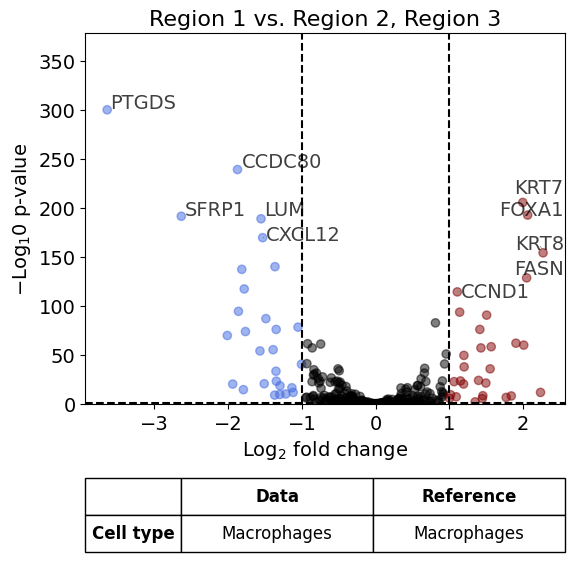

In [159]:
exp.dge(
    data_id=0,
    ref_id="rest",
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=True,
    name_col="region_name",
    figsize=(6,6),
    label_top_n=5,
    savepath="figures/dge_demo_region1_vs_rest.pdf"
)

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Saving figure to file figures/dge_demo_region2_vs_rest.pdf
Saved.


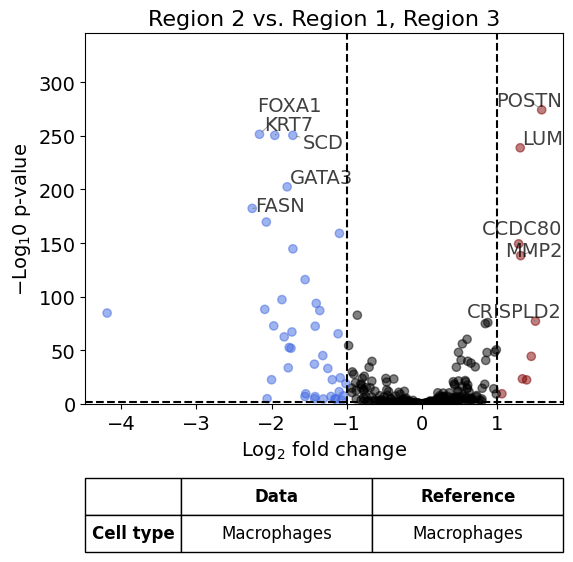

In [160]:
exp.dge(
    data_id=1,
    ref_id="rest",
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=True,
    name_col="region_name",
    figsize=(6,6),
    label_top_n=5,
    savepath="figures/dge_demo_region2_vs_rest.pdf"
)

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Saving figure to file figures/dge_demo_region3_vs_rest.pdf
Saved.


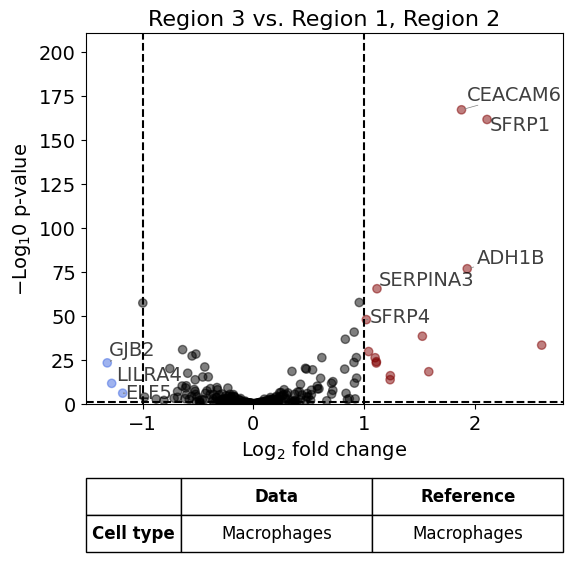

In [161]:
exp.dge(
    data_id=2,
    ref_id="rest",
    data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
    ref_cell_type_tuple="same",
    exclude_ambiguous_assignments=True,
    name_col="region_name",
    figsize=(6,6),
    label_top_n=5,
    savepath="figures/dge_demo_region3_vs_rest.pdf"
)

#### Scenario 2: Comparison of cells within one annotation against all other cells - all within the same dataset

##### Scenario 2.1: Perform analysis taking all cell types together

This scenario is only uses one dataset but also works on the `InSituExperiment` level. The `name_col` argument can be used to specify which column of the metadata should be used for generating the title.

C:\Users\ge37voy\Github\InSituPy\insitupy\_core\insitudata.py:2226: UserWarning: 3 (0.0%) cells were found to belong to both data and reference. This can happen due to overlapping annotations or non-unique cell names in the individual datasets. If you are sure that the same cell cannot be found in both data and reference, you can ignore this warning. To exclude ambiguously assigned cells from the analysis, use `exclude_ambiguous_assignments=True`.
  warn(


Exclude ambiguously assigned cells...
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


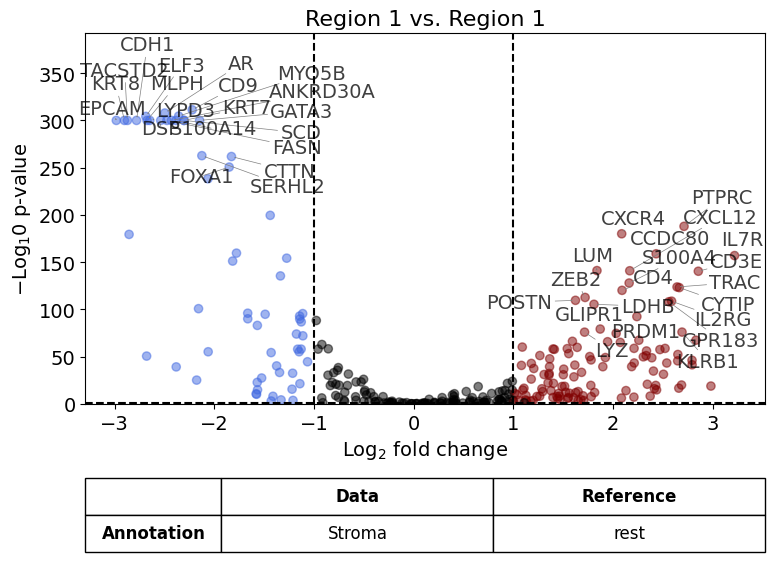

In [166]:
exp.dge(
    data_id=0,
    data_annotation_tuple=("Demo", "Stroma"),
    ref_annotation_tuple="rest",
    exclude_ambiguous_assignments=True,
    name_col="region_name",
)

#### Scenario 2: Comparison of cells within one annotation against all other cells - all within the same dataset but restricted to one cell type

##### Scenario 2.1: Perform analysis for one cell type only

This scenario is very similar to the first but the analysis is restricted to only one cell type (in this case Fibroblasts).

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


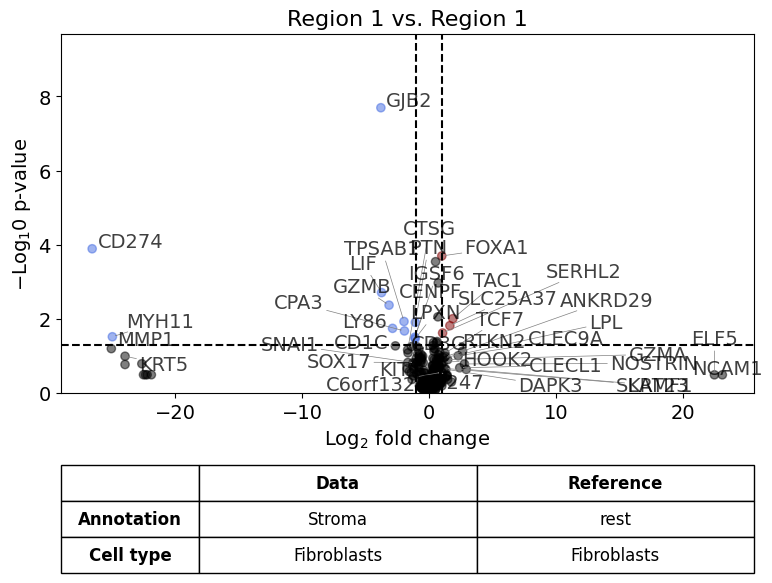

In [167]:
exp.dge(
    data_id=0,
    data_annotation_tuple=("Demo", "Stroma"),
    ref_annotation_tuple="rest",
    data_cell_type_tuple=("cell_type_dc", "Fibroblasts"),
    ref_cell_type_tuple="same",
    name_col="region_name",
)

#### Scenario 3: Comparison of two annotations between two regions or datasets - restrict analysis to one cell type

Here we compare the gene expression of one particular cell type (fibroblasts) in one histological annotation (Stroma) between two datasets. Further, we save the plot as PDF and restrict the number of labelled genes to 5.

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Saving figure to file figures/volcano_demo.pdf
Saved.


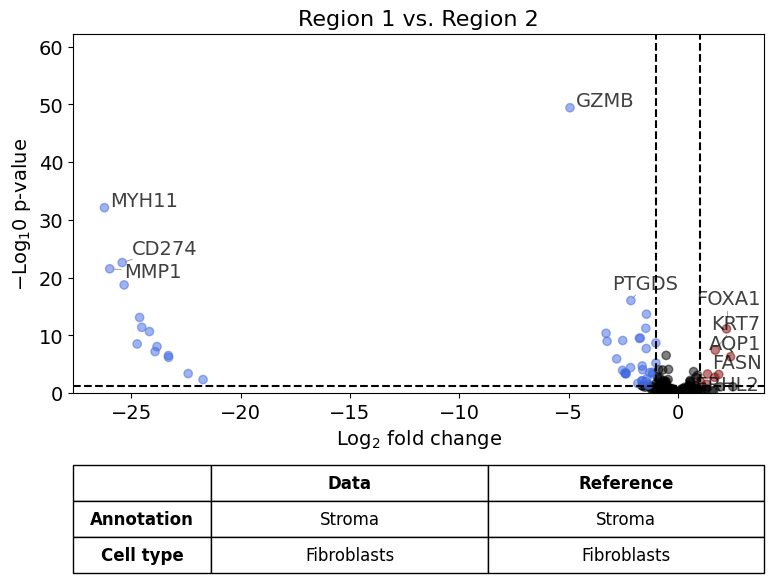

In [169]:
annotation = "Stroma"
cell_type = "Fibroblasts"

exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    data_cell_type_tuple=("cell_type_dc", cell_type),
    ref_cell_type_tuple="same",
    name_col="region_name",
    label_top_n = 5,
    savepath="figures/volcano_demo.pdf"
)

#### Scenario 4: Return results instead of Volcano plot

In [170]:
dge = exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    data_cell_type_tuple=("cell_type_tacco", cell_type),
    plot_volcano=False
)

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


In [171]:
dge.keys()

dict_keys(['results', 'params'])

In [172]:
dge_results = dge['results']

In [173]:
dge['params']

{'groupby': 'DGE_COMPARISON_COLUMN',
 'reference': 'REFERENCE',
 'method': 't-test',
 'use_raw': False,
 'layer': None,
 'corr_method': 'benjamini-hochberg'}

## GO term enrichment analysis

Gene ontology (GO) term enrichment analysis can be performed via three different analysis platforms: [STRINGdb](https://string-db.org/), [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost), and [Enrichr](https://maayanlab.cloud/Enrichr/).

In [174]:
from insitupy.utils.go import GOEnrichment, get_up_down_genes
from insitupy.plotting.go import go_plot

In [175]:
genes_up, genes_down = get_up_down_genes(dge_results, pval_threshold=0.05, logfold_threshold=1)

In [176]:
# setup go term enrichment class
go = GOEnrichment()

# run go term enrichment analysis for up-regulated genes
go.stringdb(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_up, key_added='up',
             top_n=20, organism="human", return_df=False
             )

# for down-regulated genes
go.stringdb(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_down, key_added='down',
             top_n=20, organism="human", return_df=False
             )

The results are saved in the `GOEnrichment` class and can be accessed with the respective keys.

In [177]:
go

GOEnrichment analyses performed:
  stringdb:
    - up
    - down
  gprofiler:
    - up
    - down
  enrichr:
    - up
    - down

In [178]:
enrichment = go.results["gprofiler"]["down"]
enrichment.head()

source      native                                      name  \
query 0  GO:CC  GO:0062023  collagen-containing extracellular matrix   
      1  GO:CC  GO:0031012                      extracellular matrix   
      2  GO:CC  GO:0030312          external encapsulating structure   
      3  GO:CC  GO:0005576                      extracellular region   
      4  GO:MF  GO:0019763          immunoglobulin receptor activity   

          p_value  significant  \
query 0  0.000241         True   
      1  0.001123         True   
      2  0.001134         True   
      3  0.010306         True   
      4  0.012722         True   

                                               description  term_size  \
query 0  "An extracellular matrix consisting mainly of ...        425   
      1  "A structure lying external to one or more cel...        555   
      2  "A structure that lies outside the plasma memb...        556   
      3  "The space external to the outermost structure...       4232   
      4  "Combining with the Fc region of an immunoglob...         10   

         query_size  intersection_size  effective_domain_size  precision  \
query 0          20                  6                  22115        0.3   
      1          20                  6                  22115        0.3   
      2          20                  6                  22115        0.3   
      3          20                 12                  22115        0.6   
      4          20                  2                  20196        0.1   

         Gene ratio    query                   parents  \
query 0    0.014118  query_1              [GO:0031012]   
      1    0.010811  query_1              [GO:0030312]   
      2    0.010791  query_1  [GO:0071944, GO:0110165]   
      3    0.002836  query_1              [GO:0110165]   
      4    0.200000  query_1  [GO:0004888, GO:0140375]   

                                             intersections  \
query 0         [CTSG, EGFL7, NCAM1, TPSAB1, ANGPT2, CPA3]   
      1         [CTSG, EGFL7, NCAM1, TPSAB1, ANGPT2, CPA3]   
      2         [CTSG, EGFL7, NCAM1, TPSAB1, ANGPT2, CPA3]   
      3  [DNAAF1, CTSG, EGFL7, NCAM1, TPSAB1, KRT5, ANG...   
      4                                     [FCER1A, PIGR]   

                                                 evidences  Enrichment score  
query 0         [[HDA], [HDA], [HDA], [HDA], [IBA], [HDA]]          3.617671  
      1         [[HDA], [HDA], [HDA], [HDA], [IBA], [HDA]]          2.949698  
      2         [[HDA], [HDA], [HDA], [HDA], [IBA], [HDA]]          2.945225  
      3  [[IEA], [IDA, HDA, TAS, IEA], [ISS, IBA, IEA],...          1.986905  
      4                                     [[IDA], [IDA]]          1.895452

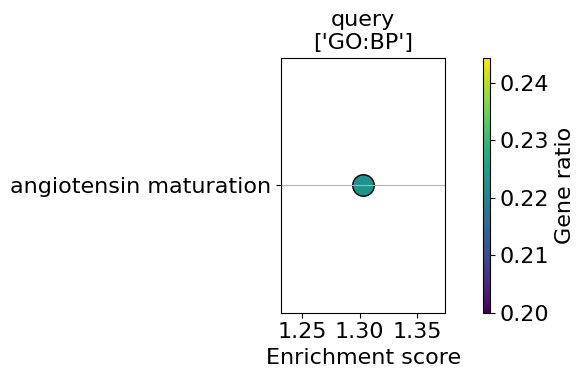

In [179]:
go_plot(enrichment=enrichment,
        style='dot',
        libraries='GO:BP',
        max_to_plot=5,
        figsize=(6,4),
        #savepath="figures/go_demo.pdf"
        )

### GO term enrichment analysis for all three regions

In [180]:
up_list = []
down_list = []
for i in range(len(exp)):
    dge = exp.dge(
        data_id=i,
        ref_id="rest",
        data_cell_type_tuple=("cell_type_dc_sub", "Macrophages"),
        plot_volcano=False
    )
    genes_up, genes_down = get_up_down_genes(dge['results'], pval_threshold=0.05, logfold_threshold=1)
    up_list.append(genes_up)
    down_list.append(genes_down)

Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


In [181]:
up_list

[['KRT7',
  'FOXA1',
  'KRT8',
  'FASN',
  'CCND1',
  'SCD',
  'APOC1',
  'EPCAM',
  'MYO5B',
  'SERHL2',
  'MLPH',
  'S100A14',
  'TCIM',
  'TENT5C',
  'ABCC11',
  'AR',
  'PCLAF',
  'TFAP2A',
  'ELF3',
  'TRAF4',
  'ELF5',
  'TUBB2B',
  'DMKN',
  'STC1',
  'LILRA4',
  'ESM1',
  'C6orf132',
  'SOX17',
  'SCGB2A1'],
 ['POSTN',
  'LUM',
  'CCDC80',
  'MMP2',
  'CRISPLD2',
  'LRRC15',
  'GJB2',
  'MEDAG',
  'LTB'],
 ['CEACAM6',
  'SFRP1',
  'ADH1B',
  'SERPINA3',
  'SFRP4',
  'KRT15',
  'OPRPN',
  'AQP1',
  'SDC4',
  'CLDN4',
  'LPL',
  'KRT23',
  'MMP12',
  'MYH11']]

In [182]:
# setup go term enrichment class
go = GOEnrichment()

for i, genes_up in enumerate(up_list):
    # run go term enrichment analysis for up-regulated genes
    go.gprofiler(target_genes=genes_up, key_added=f'Region{i+1}_up',
                top_n=20, organism="hsapiens", return_df=False
                )

The results are saved in the `GOEnrichment` class and can be accessed with the respective keys.

In [183]:
go

GOEnrichment analyses performed:
  gprofiler:
    - Region1_up
    - Region2_up
    - Region3_up

Saving figure to file figures/go_demo_region1.pdf
Saved.


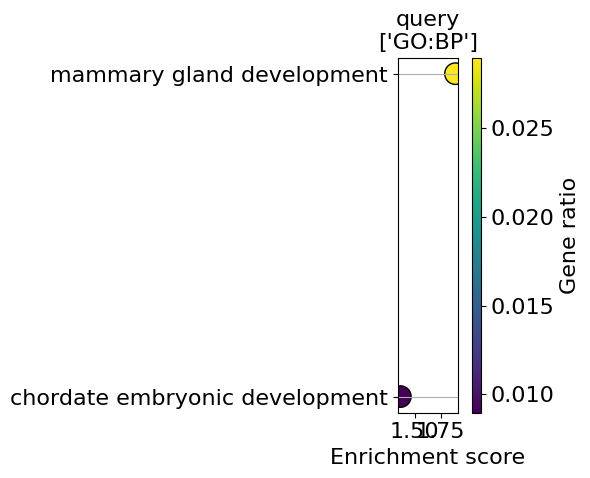

Saving figure to file figures/go_demo_region2.pdf
Saved.


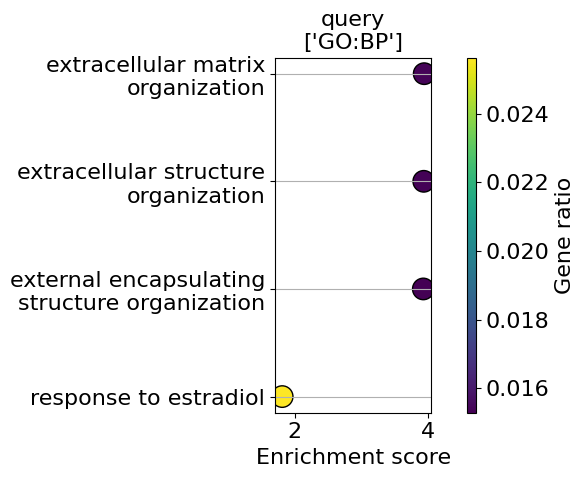

Saving figure to file figures/go_demo_region3.pdf
Saved.


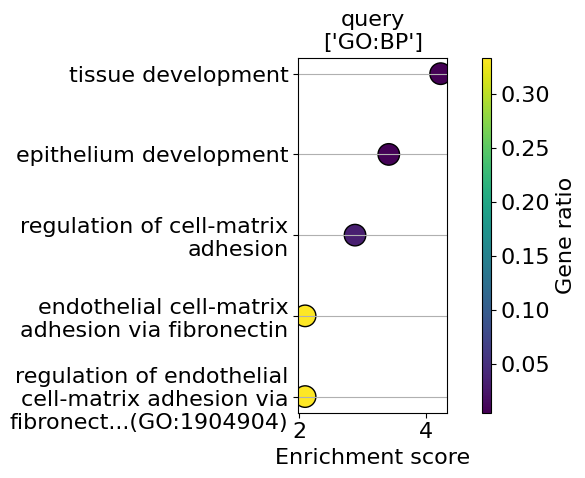

In [184]:
go_results = go.results["gprofiler"]

for i, k in enumerate(go_results.keys()):
    enrichment = go_results[k]
    go_plot(enrichment=enrichment,
            style='dot',
            libraries='GO:BP',
            max_to_plot=5,
            figsize=(6,5),
            savepath=f"figures/go_demo_region{i+1}.pdf"
            )